In [1]:
import os
import requests
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
from sklearn.utils import shuffle
import copy
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch.nn.utils import prune
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
from torchvision.models.feature_extraction import create_feature_extractor

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
SEED = 42
RNG = torch.Generator().manual_seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

import sys
sys.path.append('../')
from utils import *

Running on device: CUDA


In [2]:
import ssl

# Create an unverified SSL context
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
batch_size = 128

In [4]:
# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=True, download=False, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=False, download=False, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=1)

# download the forget and retain index split
local_path = "../example notebooks/forget_idx.npy"
# if not os.path.exists(local_path):
#     response = requests.get(
#         "https://storage.googleapis.com/unlearning-challenge/" + local_path
#     )
#     open(local_path, "wb").write(response.content)
forget_idx = np.load(local_path)

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=batch_size, shuffle=True, num_workers=1
)
# retain_loader = torch.utils.data.DataLoader(
#     retain_set, batch_size=128, shuffle=True, num_workers=1, generator=RNG
# )

In [5]:
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=batch_size, shuffle=True, num_workers=1
)

- Retain set accuracy: 99.5%
- Forget set accuracy: 99.3%
- Val set accuracy: 88.9%
- Test set accuracy: 88.3%

In [51]:
local_path = "../example notebooks/weights/weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE) #43Mbs

# load net with pre-trained weights
net = resnet18(weights=None, num_classes=10)
net.load_state_dict(weights_pretrained)
net.to(DEVICE)
net.eval();

In [52]:
val_losses = compute_losses(net, val_loader)
# test_losses = compute_losses(net, test_loader)

In [53]:
# Extract feature and pooling layers to create a Custom Model
class CustomResNet18(nn.Module):
    def __init__(self, original_model):
        super(CustomResNet18, self).__init__()
        
        # Extract features and pooling layers
        self.features = nn.Sequential(*list(original_model.children())[:-2])
        self.pooling = list(original_model.children())[-2]
    
    def forward(self, x):
        x = self.features(x)
        x = self.pooling(x)
        x = torch.squeeze(x)
        return x

custom_model = CustomResNet18(net).to(DEVICE)

In [54]:
def get_embeddings(
    net, 
    retain_loader,
    val_loader
):
    
    '''
    Feature extraction
    '''
    
    feat_extractor = create_feature_extractor(net, {'avgpool': 'feat1'})
    
    '''
    Get class weights
    '''
    
    # Retain logits
    data = np.empty((len(retain_loader.dataset), 513), dtype=object)
    idx = 0
    
    with torch.no_grad():
        for sample in retain_loader:
            # Get logits
            targets = sample[1]
            
            # Feature extraction
            inputs = sample[0]
            person_id = sample[1]
            outputs = feat_extractor(inputs.to(DEVICE))['feat1']
            feats = torch.flatten(outputs, start_dim=1)
        
            for i in range(len(targets)):
                data[idx] = [targets[i].item()] + feats[i].cpu().numpy().tolist()
                idx +=1
       
    columns = ['unique_id'] + [f'feat_{i}' for i in range(512)]
    embeddings_retain_df = pd.DataFrame(data, columns=columns)
    

    # Val logits
    data = np.empty((len(val_loader.dataset), 513), dtype=object)
    idx = 0
    
    with torch.no_grad():
        for sample in val_loader:
            # Get logits
            targets = sample[1]
            
            # Feature extraction
            inputs = sample[0]
            person_id = sample[1]
            outputs = feat_extractor(inputs.to(DEVICE))['feat1']
            feats = torch.flatten(outputs, start_dim=1)
        
            for i in range(len(targets)):
                data[idx] = [str(person_id[i].item())+'a'] + feats[i].cpu().numpy().tolist()
                idx +=1

    columns = ['unique_id'] + [f'feat_{i}' for i in range(512)]
    embeddings_val_df = pd.DataFrame(data, columns=columns)
    

    return embeddings_retain_df, embeddings_val_df

In [55]:
embeddings_retain_df, embeddings_val_df = get_embeddings(net, retain_loader, val_loader)

In [56]:
# Pre-group embeddings by unique_id for fast lookup
grouped_val_df = embeddings_val_df.groupby('unique_id').apply(lambda x: x.iloc[:, 1:].values)
grouped_retain_df = embeddings_retain_df.groupby('unique_id').apply(lambda x: x.iloc[:, 1:].values)

In [57]:
def retrain_step(net, retain_loader, steps):

    initial_retain_lr = LR
    criterion = nn.CrossEntropyLoss()
    optimizer_retain = optim.SGD(net.parameters(), lr=initial_retain_lr, momentum=0.9, weight_decay=5e-4)

    warmup_current_batch = 0
    warmup_batches = math.ceil(0.4*len(retain_loader.dataset))
    
    net.train()

    for param in net.parameters():
        param.requires_grad = False

    net.fc.weight.requires_grad = True
    net.fc.bias.requires_grad = True

    for counter, sample in enumerate(retain_loader):

        inputs, targets = sample
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        warmup_current_batch += 1

        # Warm-up for the first 'warmup_batches' batches
        if warmup_current_batch <= warmup_batches:
            adjust_learning_rate(optimizer_retain, warmup_current_batch, warmup_batches, initial_retain_lr)

        optimizer_retain.zero_grad()

        # Forward pass
        logits = net(inputs)

        # Calculate loss
        criterion = nn.CrossEntropyLoss(label_smoothing=0.4)
        classification_loss = criterion(logits, targets)
        loss = classification_loss
        loss.backward()
        optimizer_retain.step()

        if counter==steps:
            break

    # torch.save({
    #     'net': net.state_dict(),
    # }, f'./checkpoints/temp_checkpoint.pth')

    return net

Positive loss: 18.774150848388672
Neg loss: 0.0
Positive loss: 20.00497055053711
Neg loss: 0.0
Positive loss: 16.31462860107422
Neg loss: 0.0
Positive loss: 17.213193893432617
Neg loss: 0.0
Positive loss: 17.079627990722656
Neg loss: 0.0
Positive loss: 16.334117889404297
Neg loss: 0.0
Positive loss: 15.587055206298828
Neg loss: 5.403821342042647e-05
Positive loss: 15.050177574157715
Neg loss: 0.00013845025387126952
Positive loss: 17.377483367919922
Neg loss: 0.0
Positive loss: 14.489279747009277
Neg loss: 0.0
Positive loss: 16.08514404296875
Neg loss: 0.0
Forget set accuracy: 95.90%
Test set accuracy: 85.48%
--------------------


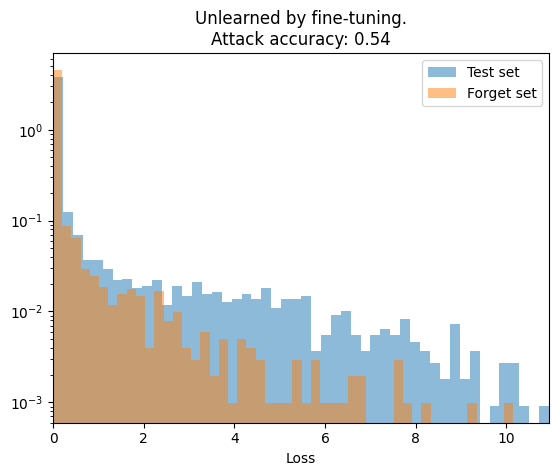

Positive loss: 16.024856567382812
Neg loss: 0.0


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [58]:
# Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    
    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) + (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

criterion = ContrastiveLoss()
optimizer = optim.AdamW(custom_model.parameters(), lr=5e-4)



for x in range(3):
    for i, batch in enumerate(forget_loader):
        custom_model.train()
        optimizer.zero_grad()
        
        inputs = batch[0].to(DEVICE)
        targets = batch[1]
        person_ids = batch[1]
        
        # Forward pass to get embeddings for the forget_batch
        forget_embeddings = custom_model(inputs)
        
        positive_pairs = []
        negative_pairs = []

        with torch.no_grad():  # Disable gradient computation to save memory
            
            # Fetch Positive Pairs
            for index, pid in enumerate(person_ids.cpu().numpy()):
                candidate_embeddings = grouped_val_df.get(str(pid)+'a', None)
                if candidate_embeddings is not None:  # If a positive pair exists
                    selected_embedding = shuffle(candidate_embeddings, n_samples=1)[0]  # Randomly select one
                else:  # Fallback to using the instance's own embedding
                    selected_embedding = forget_embeddings[index].cpu().detach().numpy()

                positive_pairs.append(torch.tensor(selected_embedding.astype(float)).float())
            # Convert to tensors for ease of computation
            positive_pairs = torch.stack(positive_pairs).to(DEVICE)


            # Fetch Negative Pairs
            for tgt in targets.cpu().numpy():
                candidate_embeddings = grouped_retain_df.get(tgt, None)
                if candidate_embeddings is not None:
                    selected_embedding = shuffle(candidate_embeddings, n_samples=1)[0]  # Randomly select one
                    negative_pairs.append(torch.tensor(selected_embedding.astype(float)).float())
                else:
                    break
            # Convert to tensors for ease of computation
            negative_pairs = torch.stack(negative_pairs).to(DEVICE)
        

        custom_model.train()

        for name, param in custom_model.named_parameters():
            param.requires_grad = True

        # Compute Contrastive Loss
        positive_loss = criterion(forget_embeddings, positive_pairs, torch.zeros(positive_pairs.shape[0]).to(DEVICE))
        print(f'Positive loss: {positive_loss}')
        negative_loss = criterion(forget_embeddings, negative_pairs, torch.ones(negative_pairs.shape[0]).to(DEVICE))
        print(f'Neg loss: {negative_loss}')
        
        # Total loss
        loss = positive_loss + negative_loss

        loss.backward()
        optimizer.step()

        if i==10:
            # print('END')
            break

    LR = 1e-5
    net = retrain_step(net, retain_loader, steps=3)#len(retain_loader.dataset))


    with torch.no_grad():
        net.eval()
        forget_acc = accuracy(net, forget_loader)
        test_acc = accuracy(net, test_loader)
    print(f"Forget set accuracy: {100.0 * forget_acc:0.2f}%")
    print(f"Test set accuracy: {100.0 * test_acc:0.2f}%")
    print('--'*10)

    ft_forget_losses = compute_losses(net, forget_loader)

    ft_mia_scores = calc_mia_acc(ft_forget_losses, val_losses)

    fig = plt.Figure(figsize=(16, 6))

    plt.title(
        f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
    )
    plt.hist(val_losses, density=True, alpha=0.5, bins=50, label="Test set")
    plt.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

    plt.xlabel("Loss")
    plt.yscale("log")
    plt.xlim((0, np.max(val_losses)))
    plt.legend()

    plt.show()

In [ ]:
print(accuracy(net, forget_loader))
print(accuracy(net, val_loader))
print(accuracy(net, test_loader))

0.9698
0.8576
0.8582
